In [1]:
%matplotlib notebook
import numpy as np
import helpers
import pandas as pd
import matplotlib as mpl
import scipy.signal
import mne
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns
import os
import subject_DM
import statsmodels.api as sm
from scipy.stats import ttest_1samp

Loaded entropies from file (S=15000, entropy_bins=50)!
Loaded dot-level measures from file (S=2000, Smin=20)!


# Investigating early visual responses in V1 and V2

## Load data

In [2]:
# label mode= None, lselection=[V1, V2], window=[0, 0.4]
srcfile = 'source_epochs_allsubs_HCPMMP1_201708151431.h5'
srcfile = os.path.join('mne_subjects', 'fsaverage', 'bem', srcfile)

In [3]:
subjects = helpers.find_available_subjects(megdatadir=helpers.megdatadir)
with pd.HDFStore(srcfile, 'r') as store:
    epochs = pd.concat(
        [store.select('label_tc', 'subject=sub').loc[(slice(None), slice(None), slice(0, 200)), :] 
         for sub in subjects])

## Helper functions for potential source flipping

In [4]:
fwdfile = os.path.join('mne_subjects/bm02/bem', 'bm02-oct-6-fwd.fif')
fwd = mne.read_forward_solution(fwdfile, surf_ori=True)
src = fwd['src']
labels = mne.read_labels_from_annot('fsaverage', parc='HCPMMP1', hemi='both')

def extract_label_time_course(epochs, labelname, time, mode='mean'):
    data = epochs.loc[(slice(None), slice(None), time), 
                      epochs.columns.map(lambda s: s[:-7]==labelname)]
    
    if mode is 'mean':
        data = data.mean(axis=1)
    elif mode == 'mean_flip':
        label = next((l for l in labels if l.name == labelname))
        
        data = data.copy().T
        data['hemi'] = data.index.map(lambda x: x[0].lower()+'h')
        data.set_index('hemi', append=True, inplace=True)
        data.reset_index(0, inplace=True)
        data['level_0'] = data['level_0'].map(lambda x: int(x[-6:]))
        data.set_index('level_0', append=True, inplace=True)
        data.sort_index(inplace=True)

        flip = mne.label_sign_flip(label, src)
        
        data = (flip[:, None] * data).mean().T
        
    return data


def flip_label_currents(epochs, return_flippat=False):
    flipped = epochs.copy()
    
    # which labels are in epochs?
    lnames = pd.Series([name[:-7] for name in epochs.columns]).unique()
    
    if return_flippat:
        flippat = pd.Series(np.zeros(epochs.columns.size), index=epochs.columns)
    
    for name in lnames:
        label = next((l for l in labels if l.name == name))
        flip = mne.label_sign_flip(label, src)
        
        snames = epochs.columns[epochs.columns.map(lambda s: s.startswith(name))]
        
        # check that all vertex indices are in standard increasing order
        assert np.all(np.diff(snames.map(lambda s: int(s[-6:]))) > 0), \
                'vertex indices are not increasing'
        
        # check that number of sources is consistent
        assert flip.size == snames.size, \
                'number of sources to flip is not equal to number of sources in label'
        
        if return_flippat:
            flippat[snames] = flip
        
        flipped[snames] = flipped[snames] * flip
    
    if return_flippat:
        return flipped, flippat
    else:
        return flipped

Reading forward solution from mne_subjects/bm02/bem/bm02-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (8196 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
    Converting to surface-based source orientations...
    Average patch normals will be employed in the rotation to the local surface coordinates....
[done]
Reading labels from parcellation..
   read 181 labels from /media/bitzer/Data/mne_subjects/fsaverage/label/lh.HCPMMP1.annot
   read 181 labels from /media/bitzer/Data/mne_subjects/fsaverage/label/rh.HCPMMP1.annot
[done]


## Visual evoked responses

In [5]:
vefs = epochs.mean(level='time')

<IPython.core.display.Javascript object>


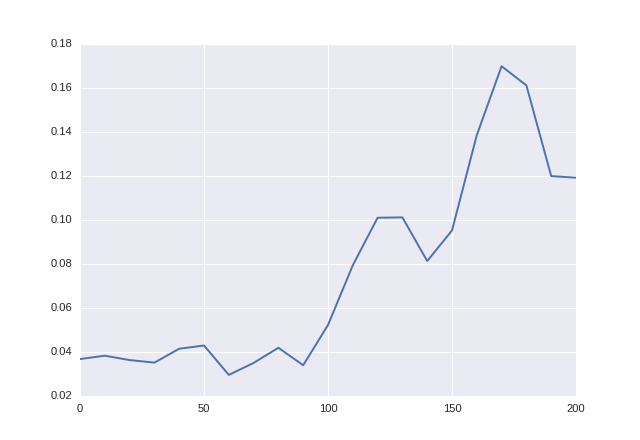

In [6]:
plt.figure()
plt.plot(vefs.index, vefs.abs().max(axis=1));

<IPython.core.display.Javascript object>


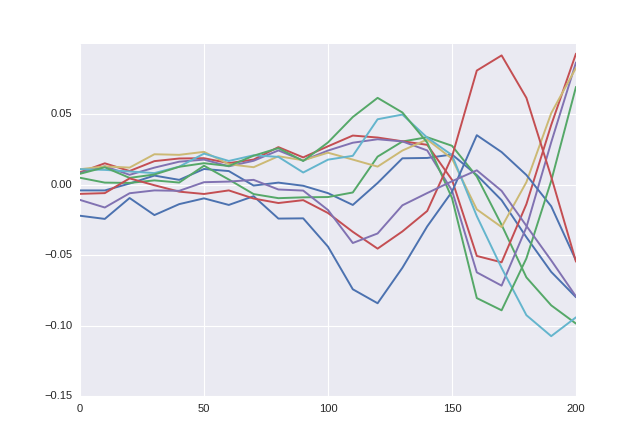

In [7]:
plt.figure()
plt.plot(vefs.index, vefs.iloc[:, slice(0, 10)]);

## Regression for responses to top/bottom and left/right dot locations at 80 ms after first dot onset

### Setup design matrix

In [8]:
pxthr = 50

DM = subject_DM.get_trial_DM([1], r_names=['dot_x', 'dot_y', 'intercept'])
DM = DM.loc[subjects.tolist()]

DM['horizontal'] = DM.dot_x_1.copy()
DM.loc[DM.horizontal.abs() < pxthr, 'horizontal'] = 0
DM['left'] = DM.horizontal < 0
DM['right'] = DM.horizontal > 0

DM['vertical'] = DM.dot_y_1.copy()
DM.loc[DM.vertical.abs() < pxthr, 'vertical'] = 0
DM['top'] = DM.vertical > 0
DM['bottom'] = DM.vertical < 0

There may be a problem, because the y-coordinates are not balanced between top and bottom. This is because, when Hame generated the stimuli, she flipped the x-coordinates of the generated dots to generate the second half of trials, but she did not flip their y-coordinates. This means that she doubled the unbalanced y-counts and made the y-coordinates even more unbalanced across the whole set of stimuli. Specifically this lead to many more dots shown in the top half of the screen.

In [9]:
DM.describe()

,dot_x_1,dot_y_1,intercept,horizontal,vertical
count,16320.000000,16320.000000,16320.0,16320.000000,16320.000000
mean,0.000000,7.416667,1.0,0.000000,1.637500
std,66.725791,72.220179,0.0,62.000119,68.570481
min,-173.000000,-176.000000,1.0,-173.000000,-176.000000
25%,-44.500000,-47.000000,1.0,0.000000,0.000000
50%,0.000000,33.000000,1.0,0.000000,0.000000
75%,44.500000,60.250000,1.0,0.000000,60.250000
max,173.000000,149.000000,1.0,173.000000,149.000000


In [10]:
DM.sum()

dot_x_1            0.0
dot_y_1       121040.0
intercept      16320.0
horizontal         0.0
left            3332.0
right           3332.0
vertical       26724.0
top             5032.0
bottom          3808.0
dtype: float64

<IPython.core.display.Javascript object>


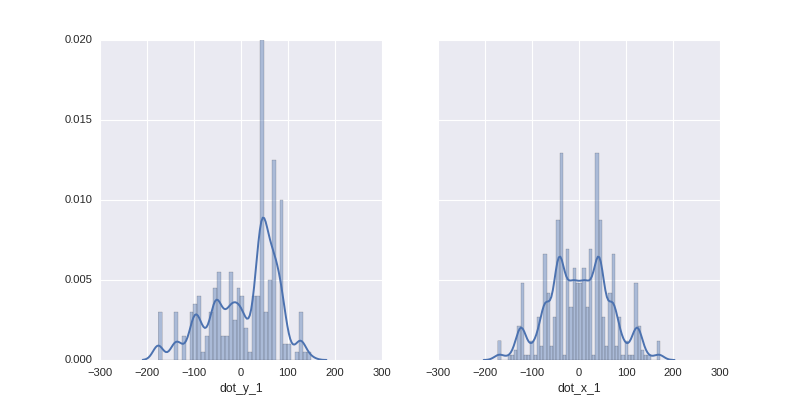

In [11]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=[10, 5])
sns.distplot(DM.dot_y_1, ax=axes[0]);
sns.distplot(DM.dot_x_1, ax=axes[1]);

<IPython.core.display.Javascript object>


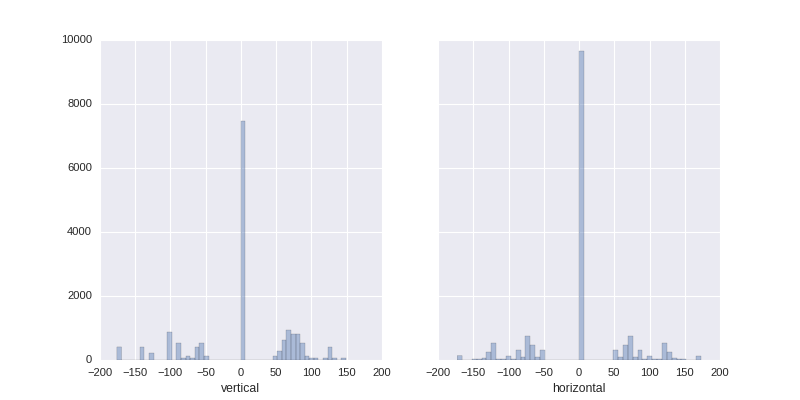

In [12]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=[10, 5])
sns.distplot(DM.vertical, ax=axes[0], kde=False);
sns.distplot(DM.horizontal, ax=axes[1], kde=False);

### test: check V1 average regression
Here you can quickly check a basic regression analysis on the mean currents within V1. Specifically, I used this to see what effect flipping of source currents has on correlations with x- and y-coordinates.

In [13]:
DMV1 = subject_DM.get_trial_DM([1], r_names=['dot_x', 'dot_y', 'intercept'])
DMV1.describe()

,dot_x_1,dot_y_1,intercept
count,17280.000000,17280.000000,17280.0
mean,0.000000,7.416667,1.0
std,66.725677,72.220056,0.0
min,-173.000000,-176.000000,1.0
25%,-44.500000,-47.000000,1.0
50%,0.000000,33.000000,1.0
75%,44.500000,60.250000,1.0
max,173.000000,149.000000,1.0


In [14]:
DMV1 = (DMV1 - DMV1.mean()) / DMV1.std()
DMV1['intercept'] = np.ones(DMV1.shape[0])

In [15]:
time = 180

# 4th argument: 'mean' (default) or 'mean_flip'
data = extract_label_time_course(epochs, 'L_V1_ROI-lh', time, 'mean')

data = (data - data.mean()) / data.std()

fl = pd.DataFrame([], 
        index=subjects,
        columns=pd.MultiIndex.from_product([['beta', 'bse'], 
              DMV1.columns], names=['measure', 'regressor']), 
              dtype=np.float64)

for sub in subjects:
    res = sm.OLS(data.loc[(sub, slice(None), time)].values,
                 DMV1.loc[sub, :].values,
                 hasconst=True).fit()
    
    fl.loc[sub, ('beta', slice(None))] = res.params
    fl.loc[sub, ('bse', slice(None))] = res.bse
    
dotx_t, dotx_p = ttest_1samp(fl.loc[:, ('beta', 'dot_x_1')], 0)
doty_t, doty_p = ttest_1samp(fl.loc[:, ('beta', 'dot_y_1')], 0)
print('x t-value: %s' % dotx_t)
print('y t-value: %s' % doty_t)

x t-value: 1.92847980523
y t-value: -0.205905099624


### run regression for all selected sources (V1+V2)

In [16]:
time = 180
flip = False

regressors = ['intercept', 'left', 'right', 'top', 'bottom']

srclabels = epochs.columns
first_level = pd.DataFrame([], 
        index=srclabels,
        columns=pd.MultiIndex.from_product([subjects, ['beta', 'bse'], 
              regressors], names=['subject', 'measure', 'regressor']), 
              dtype=np.float64)
first_level.sort_index(axis=1, inplace=True)

for sub in subjects:
    print('\rsubject = %2d' % (sub, ), end='')
    if flip:
        data = flip_label_currents(epochs.loc[(sub, slice(None), time)])
    else:
        data = epochs.loc[(sub, slice(None), time)]
    
    for label in srclabels:
        res = sm.OLS(data[label].values, 
                     DM.loc[sub, first_level.columns.levels[2]].values.astype(int), 
                     hasconst=True).fit()
                
        first_level.loc[label, (sub, 'beta', slice(None))] = (
            res.params)
        first_level.loc[label, (sub, 'bse', slice(None))] = (
            res.bse)

subject = 37

In [17]:
second_level = pd.DataFrame([], 
        index=srclabels, 
        columns=pd.MultiIndex.from_product([['mean', 'std', 'mlog10p'], 
              regressors], names=['measure', 'regressor']), dtype=np.float64)
second_level.sort_index(axis=1, inplace=True)

for label in srclabels:
    params = first_level.loc[label, (slice(None), 'beta', slice(None))]
    params = params.reset_index(level='regressor').pivot(columns='regressor')

    second_level.loc[label, ('mean', slice(None))] = (
            params.mean().values)
    second_level.loc[label, ('std', slice(None))] = (
            params.std().values)
    _, pvals = ttest_1samp(params.values, 0, axis=0)
    second_level.loc[label, ('mlog10p', slice(None))] = (
            -np.log10(pvals))

<IPython.core.display.Javascript object>


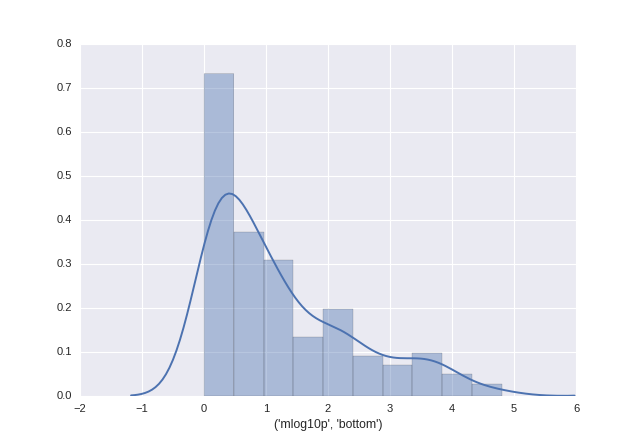

In [18]:
fig, ax = plt.subplots()
sns.distplot(second_level.loc[:, ('mlog10p', 'bottom')], ax=ax);

In [19]:
vertical = (  first_level.loc[:, (slice(None), 'beta', 'top')].values 
            - first_level.loc[:, (slice(None), 'beta', 'bottom')].values)
vertical_t, vertical_p = ttest_1samp(vertical, 0, axis=1)

<IPython.core.display.Javascript object>


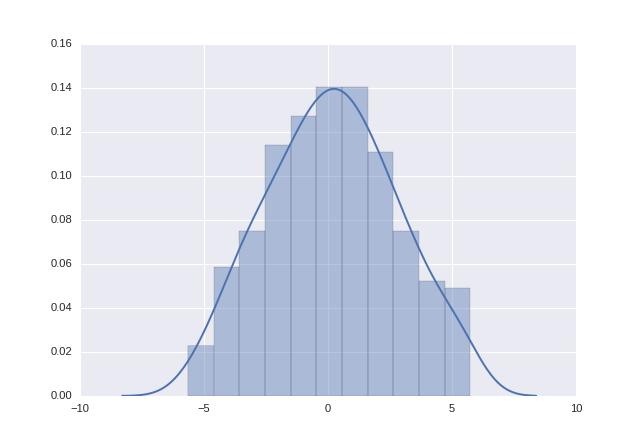

In [20]:
fig, ax = plt.subplots()
sns.distplot(vertical_t, ax=ax);

In [21]:
np.sort(vertical_p)[:20]

array([  2.07338486e-06,   2.11547151e-06,   2.43580490e-06,
         2.62517220e-06,   2.72239115e-06,   3.35122065e-06,
         3.85069288e-06,   5.80526303e-06,   5.96600111e-06,
         7.13053794e-06,   7.27636055e-06,   7.38133341e-06,
         8.12875850e-06,   1.01018427e-05,   1.16891708e-05,
         2.04559781e-05,   2.32950462e-05,   2.44502622e-05,
         2.84860430e-05,   3.14756444e-05])

In [22]:
horizontal = (  first_level.loc[:, (slice(None), 'beta', 'left')].values 
              - first_level.loc[:, (slice(None), 'beta', 'right')].values)
horizontal_t, horizontal_p = ttest_1samp(horizontal, 0, axis=1)

<IPython.core.display.Javascript object>


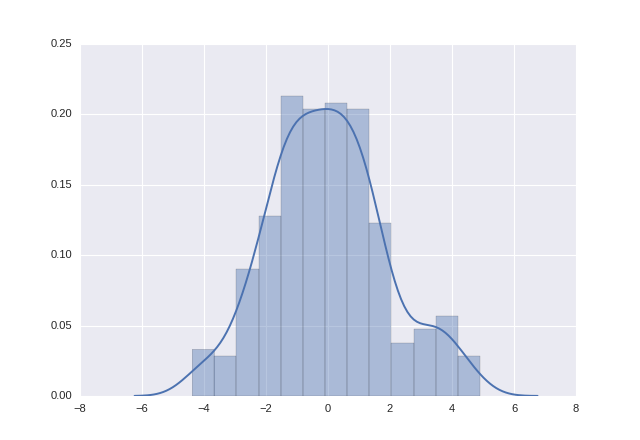

In [23]:
fig, ax = plt.subplots()
sns.distplot(horizontal_t, ax=ax);

In [24]:
np.sort(horizontal_p)[:20]

array([  2.47344458e-05,   6.55622531e-05,   6.65801174e-05,
         8.20804222e-05,   1.11959706e-04,   1.12938791e-04,
         1.22511255e-04,   1.66625864e-04,   1.78096340e-04,
         2.03006367e-04,   2.36550246e-04,   3.88342318e-04,
         4.04283873e-04,   4.75387722e-04,   4.82674208e-04,
         5.08498321e-04,   5.22085019e-04,   5.50143578e-04,
         8.82673845e-04,   1.00862343e-03])

### save results in temporary file to visualise with show_VEF_sources.py

In [25]:
second_level.head()

measure                 mean                                          \
regressor             bottom intercept      left     right       top   
L_V1_ROI-lh_000573  0.042981 -0.062984 -0.038991  0.101023  0.010019   
L_V1_ROI-lh_001397  0.006974 -0.079433 -0.034883  0.070134  0.015743   
L_V1_ROI-lh_006390 -0.043739  0.002103 -0.046875 -0.017475  0.024330   
L_V1_ROI-lh_010591 -0.036482 -0.017297 -0.045825 -0.011335  0.023734   
L_V1_ROI-lh_014480 -0.032347  0.012237 -0.051463  0.028796  0.005897   

measure              mlog10p                                          \
regressor             bottom intercept      left     right       top   
L_V1_ROI-lh_000573  0.632121  0.967464  0.695528  1.736635  0.168782   
L_V1_ROI-lh_001397  0.098687  1.544894  0.527966  1.210301  0.264270   
L_V1_ROI-lh_006390  1.114088  0.029551  0.793466  0.271937  0.399996   
L_V1_ROI-lh_010591  0.885374  0.278997  0.724614  0.165737  0.385542   
L_V1_ROI-lh_014480  0.693816  0.178697  0.941594  0.333102  0.085847   

measure                  std                                          
regressor             bottom intercept      left     right       top  
L_V1_ROI-lh_000573  0.206406  0.222152  0.174485  0.237355  0.139445  
L_V1_ROI-lh_001397  0.156610  0.202215  0.191754  0.211357  0.149782  
L_V1_ROI-lh_006390  0.139664  0.147466  0.190563  0.162380  0.165712  
L_V1_ROI-lh_010591  0.137068  0.157376  0.199005  0.160293  0.166403  
L_V1_ROI-lh_014480  0.145013  0.162101  0.185044  0.226838  0.150450

In [26]:
with pd.HDFStore('VEFdata_tmp.h5', 'w') as store:
    store['options'] = pd.Series({'time': time})
    store['second_level'] = second_level
    store['horizontal'] = pd.DataFrame(np.c_[horizontal_t, horizontal_p], 
                                       index=second_level.index, columns=['tval', 'pval'])
    store['vertical'] = pd.DataFrame(np.c_[vertical_t, vertical_p], 
                                      index=second_level.index, columns=['tval', 'pval'])